In [425]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import numpy as np
import pandas as pd
import datetime
import os
import csv
import random
import io
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

In [426]:
num_lags = 3
#1,5,10,20,30
timesteps = 30
setting = 'LSTM_daily_R3_'+str(timesteps)
title = 'LSTM (ReLU, 3 Hidden Layers) Model Performance for Daily Data: '+str(timesteps)+' Time Step'
if timesteps != 1:
    title += 's'

In [427]:
# read in data
df = pd.read_csv('j17_daily.csv')
pd.DataFrame.reset_index(df, drop=True)
del df['Site']
# standardize data
def z_score_calc(dataframe,col_name):
    sub = dataframe[col_name]
    mean = sub.mean()
    std = sub.std()
    dataframe['Z Scores'] = (sub - mean) / std
    return dataframe['Z Scores'], mean, std
z_scores = pd.DataFrame()
pd.DataFrame.reset_index(z_scores, drop=True)
z_scores["DailyHighDate"] = df['DailyHighDate']
z_scores['WaterLevelElevation'] = df['WaterLevelElevation']
z_scores['Z Scores'], mean, std = z_score_calc(df,'WaterLevelElevation')
z_scores.to_csv("j17wl_daily_z_scores.csv")
# generate csv based on number of lags
def make_csv(num_lags,gwl_num,df,col_name,csv_name):
    result = pd.DataFrame()
    pd.DataFrame.reset_index(result, drop=True)
    data = df[col_name]
    pd.DataFrame.reset_index(data, drop=True)
    name = ""
    for i in range(num_lags):
        name = "Max GWL: t-" + str(num_lags-i)
        list_data = data[num_lags+gwl_num-1-i:(len(data)-i)]
        result[name] = np.array(list_data)
    if gwl_num > 1:
        result['Max GWL (predicted,updated): t+' + str(gwl_num-1)] = data[0:len(data)-num_lags-gwl_num+1]
    else:
        result['Max GWL (predicted,updated): t'] = data[0:len(data)-num_lags-gwl_num+1]
    #result = result.sample(frac=1)
    result.to_csv(csv_name)
make_csv(num_lags,timesteps,z_scores,'Z Scores','data.csv')
# prepare data
cols = []
for i in range(num_lags):
    cols.append(i+1)
ds_x = np.genfromtxt('data.csv',delimiter=",",usecols=cols)
ds_y = np.genfromtxt('data.csv',delimiter=",",usecols=num_lags+1)
ds_x = ds_x[1:] # remove header
ds_y = ds_y[1:]
# ~80% training
ds_train_x = ds_x[:int(0.8*len(ds_x))]
ds_train_y = ds_y[:int(0.8*len(ds_x))]
# ~20% validating
ds_val_x = ds_x[int(0.8*len(ds_x)):]
ds_val_y = ds_y[int(0.8*len(ds_x)):]
# reshape data from [samples, timesteps] into [samples, timesteps, features]
ds_train_x = ds_train_x.reshape((ds_train_x.shape[0], ds_train_x.shape[1], 1))
ds_val_x = ds_val_x.reshape((ds_val_x.shape[0], ds_val_x.shape[1], 1))

In [439]:
ds_train_x

array([[[ 0.14865702],
        [ 0.20097308],
        [ 0.23359369]],

       [[ 0.06679777],
        [ 0.14865702],
        [ 0.20097308]],

       [[ 0.07233712],
        [ 0.06679777],
        [ 0.14865702]],

       ...,

       [[-1.13954907],
        [-1.16478388],
        [-1.15493615]],

       [[-1.14324197],
        [-1.13954907],
        [-1.16478388]],

       [[-1.15062777],
        [-1.14324197],
        [-1.13954907]]])

In [441]:
epochs=20
batch_size=100
model = Sequential()
model.add(LSTM(10,input_shape=(num_lags, 1),activation='relu')) #return_sequences=True
#model.add(LSTM(10,return_sequences=True))
#model.add(LSTM(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.MeanAbsoluteError()])
history = model.fit(ds_train_x, ds_train_y, batch_size=batch_size, epochs=epochs, verbose=1)
# apply to predictions
predictions = model.predict(ds_val_x)
result = []
for i in predictions:
  result.append(i[0])
result = np.array(result)
predicted_vals = result * std + mean
true_vals = ds_val_y * std + mean
diff = true_vals - predicted_vals
corr_m = np.corrcoef(result, true_vals)
r2 = corr_m[0,1] ** 2
print('R2 = ' + str(r2*100) + "%")
mse = np.square(diff).mean()
print('MSE = ' + str(mse))
mae = np.mean(np.abs(diff))
print('MAE = ' + str(mae))

Epoch 1/20


KeyboardInterrupt: 

In [436]:
#plt.plot(history.history['mean_absolute_error'])

In [430]:
tf.keras.models.save_model(model,'Saved Models/'+setting)

INFO:tensorflow:Assets written to: Saved Models/LSTM_daily_R3_30/assets


INFO:tensorflow:Assets written to: Saved Models/LSTM_daily_R3_30/assets


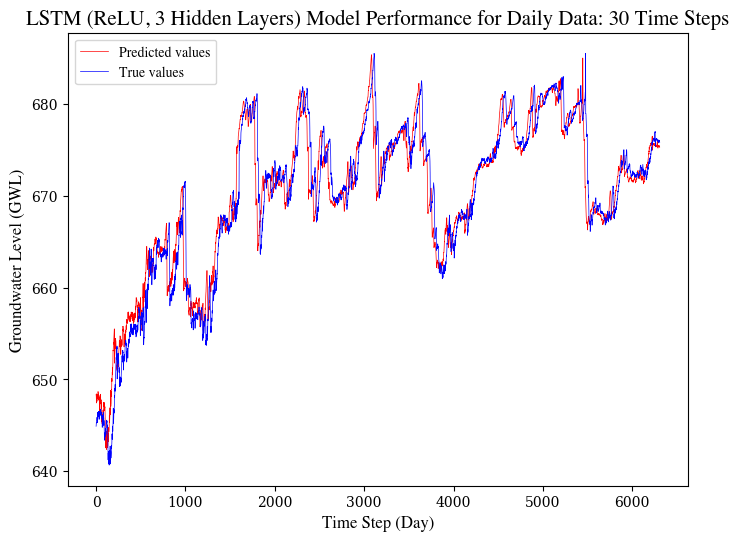

In [431]:
plt.rcParams['font.family'] = 'serif'
f='Times'
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title(title, family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})
plt.savefig('Figures/'+setting+'_serif.png', dpi=300)
plt.show()

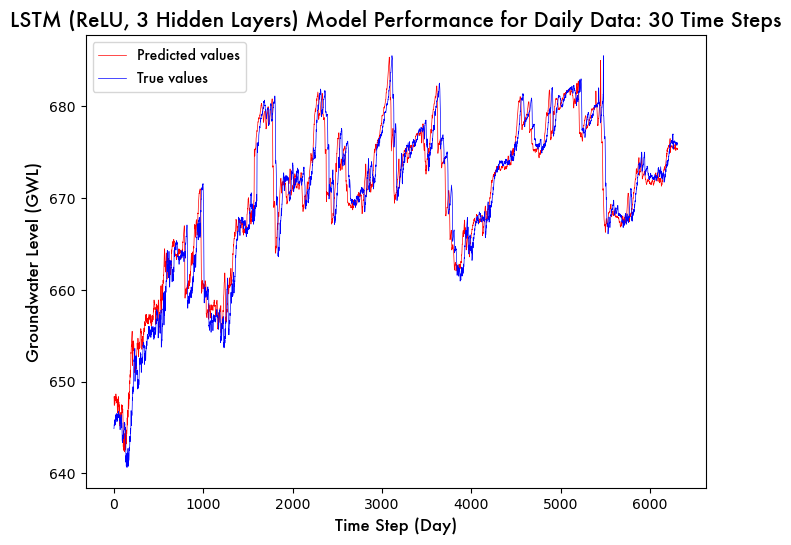

In [432]:
plt.rcParams['font.family'] = 'sans-serif'
f='Futura'
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title(title, family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})
plt.savefig('Figures/'+setting+'_sans-serif.png', dpi=300)
plt.show()

In [433]:
print('R2 = ' + str(r2*100) + "%")
print('MSE = ' + str(mse))
print('MAE = ' + str(mae))

R2 = 90.87405559970789%
MSE = 7.334528597099199
MAE = 1.8908359718685601
